In [1]:
import os
import json

from ast import literal_eval
from typing import Tuple, List

import numpy as np
import pandas as pd

from scipy.stats import gaussian_kde
from scipy.signal import butter, sosfiltfilt

import seaborn as sns
import matplotlib.pyplot as plt

!pip install seaborn

In [2]:
output_names = ['com_x', 'com_y', 'com_z']
exercises = ['Sta', 'Ste', 'W']

subtitle_mapping = {
    "Sta_com_x_centred": "Single Leg Stance CoM X-Axis",
    "Sta_com_y_centred": "Single Leg Stance CoM Y-Axis",
    "Sta_com_z_centred": "Single Leg Stance CoM Z-Axis",
    "Ste_com_x_centred": "Stepping CoM X-Axis",
    "Ste_com_y_centred": "Stepping CoM Y-Axis",
    "Ste_com_z_centred": "Stepping CoM Z-Axis",
    "W_com_x_centred": "Waves CoM X-Axis",
    "W_com_y_centred": "Waves CoM Y-Axis",
    "W_com_z_centred": "Waves CoM Z-Axis"
}

propper_naming_map = {
    "com_x-Sta": "Single Leg Stance CoM X-Axis",
    "com_y-Sta": "Single Leg Stance CoM Y-Axis",
    "com_z-Sta": "Single Leg Stance CoM Z-Axis",
    "com_x-Ste": "Stepping CoM X-Axis",
    "com_y-Ste": "Stepping CoM Y-Axis",
    "com_z-Ste": "Stepping CoM Z-Axis",
    "com_x-W": "Waves CoM X-Axis",
    "com_y-W": "Waves CoM Y-Axis",
    "com_z-W": "Waves CoM Z-Axis",
}

  Saved: grouped_plots/com_x_all_conditions.png
  Saved: grouped_plots/com_y_all_conditions.png
  Saved: grouped_plots/com_z_all_conditions.png


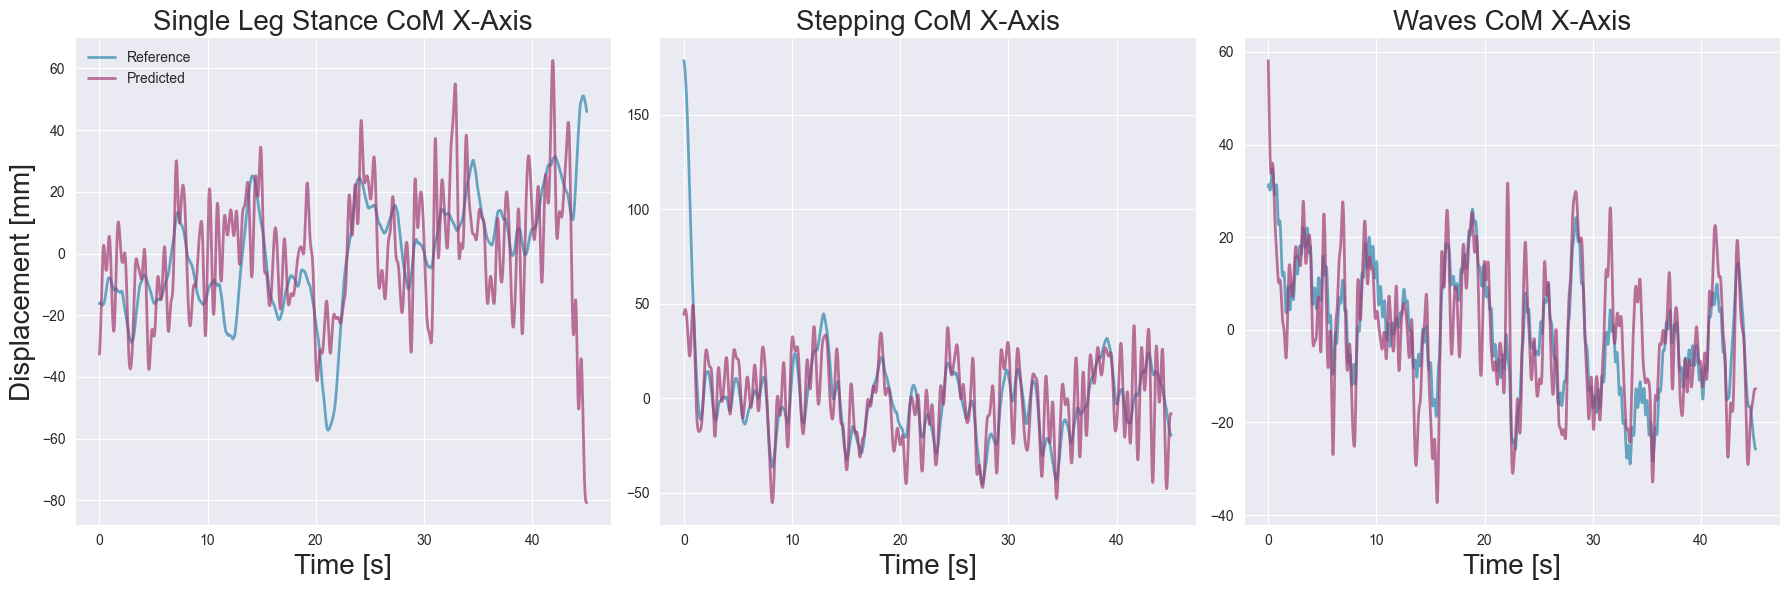

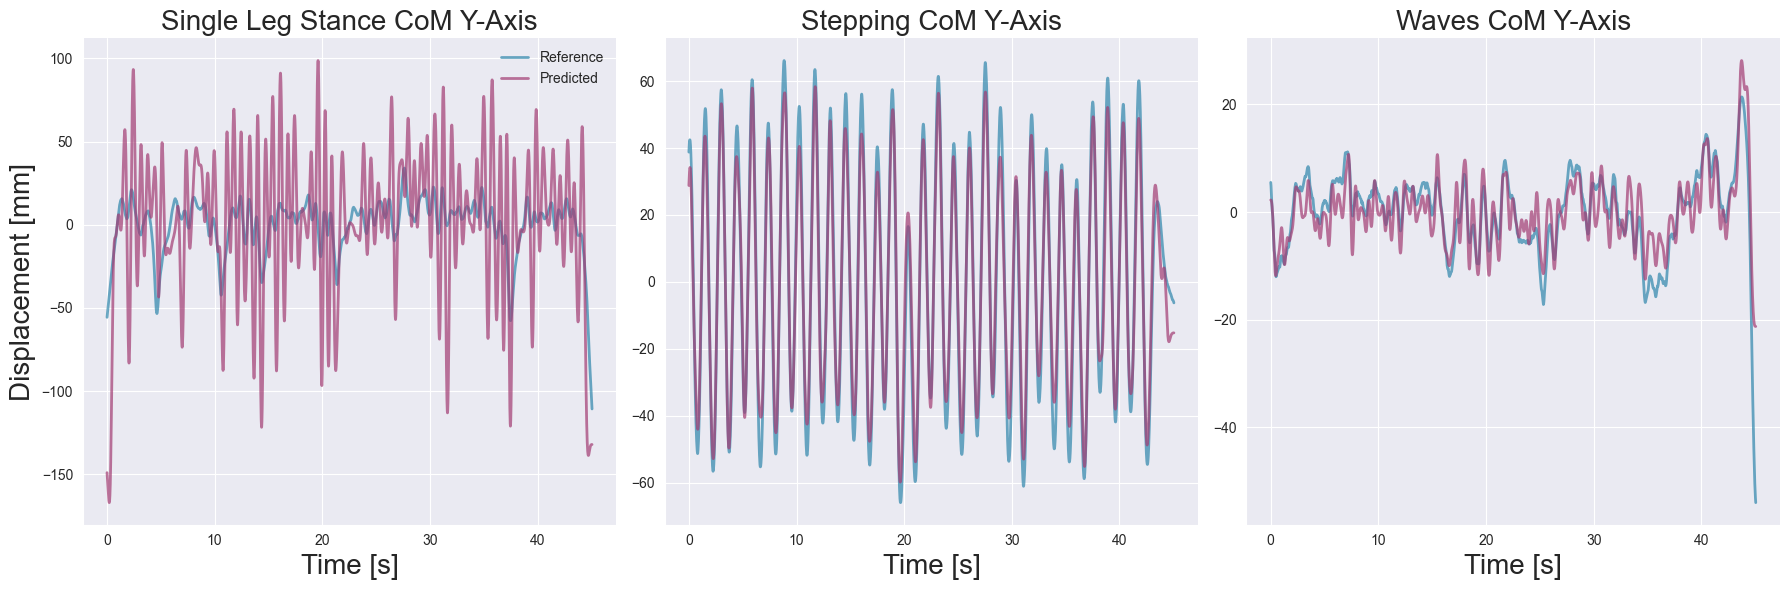

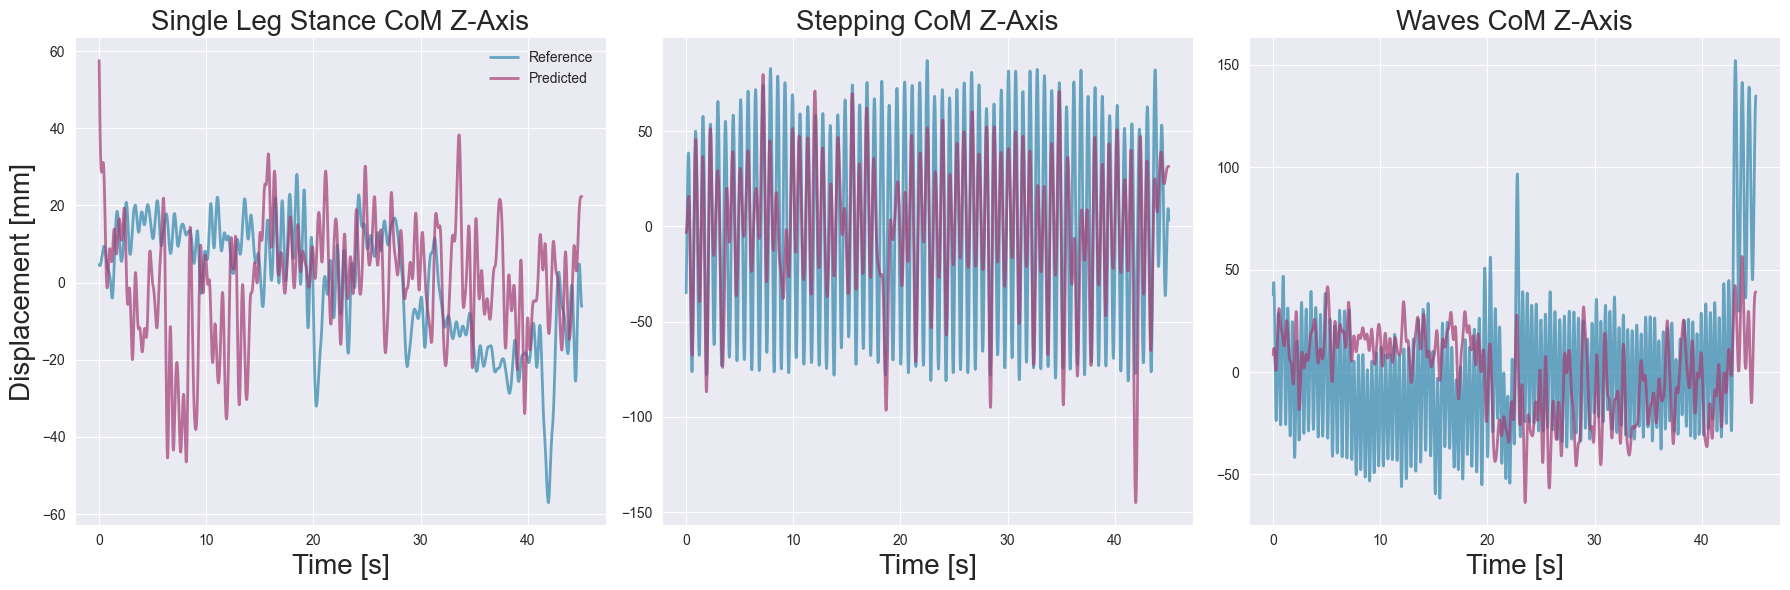


All plots created successfully!


In [4]:
font_size = 20


def butter_lowpass_filter(data: np.ndarray,
                          cutoff: float,
                          fs: float,
                          order: int = 4) -> np.ndarray:
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    sos = butter(order, normal_cutoff, btype='low', analog=False, output='sos')
    return sosfiltfilt(sos, data)


def plot_multi_panel_comparison(cases_group: List[List[str]],
                                results_dir: str = "results",
                                model_suffix: str = "_centred_DeeperConvLSTMNet_e_10",
                                sampling_frequency: float = 500,
                                cutoff_frequency: float = 20,
                                filter_order: int = 4,
                                figsize: Tuple[int, int] = (18, 6)) -> plt.Figure:
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    reference_color = '#2E86AB'
    predicted_color = '#A23B72'

    for idx, (output_name, exercise, participant_id) in enumerate(cases_group):
        ax = axes[idx]

        model_name = f"{exercise}_{exercise}_{output_name}{model_suffix}"
        filepath = f"../{results_dir}/test_result_{model_name}.csv"
        result_df = pd.read_csv(filepath)
        participant_data = result_df[result_df.id == participant_id]

        predicted_str = participant_data.filtered_predicted.iloc[0]
        expected_str = participant_data.filtered_expected.iloc[0]

        predicted = np.array(literal_eval(predicted_str), dtype=float)
        expected = np.array(literal_eval(expected_str), dtype=float)

        filtered_predicted = butter_lowpass_filter(
            predicted,
            2,
            sampling_frequency,
            filter_order
        )
        filtered_expected = butter_lowpass_filter(
            expected,
            cutoff_frequency,
            sampling_frequency,
            filter_order
        )

        time_vector = np.arange(len(expected)) / sampling_frequency

        ax.plot(time_vector, filtered_expected,
                alpha=0.7,
                label='Reference',
                linewidth=2,
                color=reference_color)

        ax.plot(time_vector, filtered_predicted,
                alpha=0.7,
                label='Predicted',
                linewidth=2,
                color=predicted_color)

        condition_map = {'Sta': 'Single Leg Stance', 'Ste': 'Stepping', 'W': 'Waves'}
        axis_map = {'com_x': 'CoM X-Axis', 'com_y': 'CoM Y-Axis', 'com_z': 'CoM Z-Axis'}

        ax.set_title(
            f"{condition_map.get(exercise, exercise)} {axis_map.get(output_name, output_name)}",
            fontsize=font_size
        )

        ax.set_xlabel("Time [s]", fontsize=font_size)

        if idx == 0:
            ax.set_ylabel("Displacement [mm]", fontsize=font_size)

        ax.spines[['right', 'top']].set_visible(False)

        if idx == 0:
            ax.legend(loc='best', frameon=False)

    plt.tight_layout()
    return fig


def create_three_grouped_plots(mean_cases: List[List[str]],
                               results_dir: str = "results",
                               model_suffix: str = "_centred_DeeperConvLSTMNet_e_10",
                               save_figures: bool = False,
                               output_dir: str = "plots") -> List[plt.Figure]:
    if save_figures:
        os.makedirs(output_dir, exist_ok=True)

    figures = []

    fig1 = plot_multi_panel_comparison(
        cases_group=mean_cases[0:3],
        results_dir=results_dir,
        model_suffix=model_suffix
    )

    figures.append(fig1)
    if save_figures:
        fig1.savefig(f"{output_dir}/com_x_all_conditions.png", dpi=600, bbox_inches='tight')
        print(f"  Saved: {output_dir}/com_x_all_conditions.png")

    fig2 = plot_multi_panel_comparison(
        cases_group=mean_cases[3:6],
        results_dir=results_dir,
        model_suffix=model_suffix
    )

    figures.append(fig2)
    if save_figures:
        fig2.savefig(f"{output_dir}/com_y_all_conditions.png", dpi=600, bbox_inches='tight')
        print(f"  Saved: {output_dir}/com_y_all_conditions.png")

    fig3 = plot_multi_panel_comparison(
        cases_group=mean_cases[6:9],
        results_dir=results_dir,
        model_suffix=model_suffix
    )

    figures.append(fig3)
    if save_figures:
        fig3.savefig(f"{output_dir}/com_z_all_conditions.png", dpi=600, bbox_inches='tight')
        print(f"  Saved: {output_dir}/com_z_all_conditions.png")

    plt.show()
    return figures


mean_cases = [
    ['com_x', 'Sta', 'ION'],  # X-axis Static
    ['com_x', 'Ste', 'VWM'],  # X-axis Step
    ['com_x', 'W', 'ION'],  # X-axis Walking
    ['com_y', 'Sta', 'NIN'],  # Y-axis Static
    ['com_y', 'Ste', 'SXN'],  # Y-axis Step
    ['com_y', 'W', 'BDN'],  # Y-axis Walking
    ['com_z', 'Sta', 'KOD'],  # Z-axis Static
    ['com_z', 'Ste', 'LON'],  # Z-axis Step
    ['com_z', 'W', 'NIN']  # Z-axis Walking
]

figures = create_three_grouped_plots(
    mean_cases=mean_cases,
    save_figures=True,
    output_dir="grouped_plots"
)

print("\nAll plots created successfully!")

  Saved: grouped_plots/com_all_conditions_3x3.png


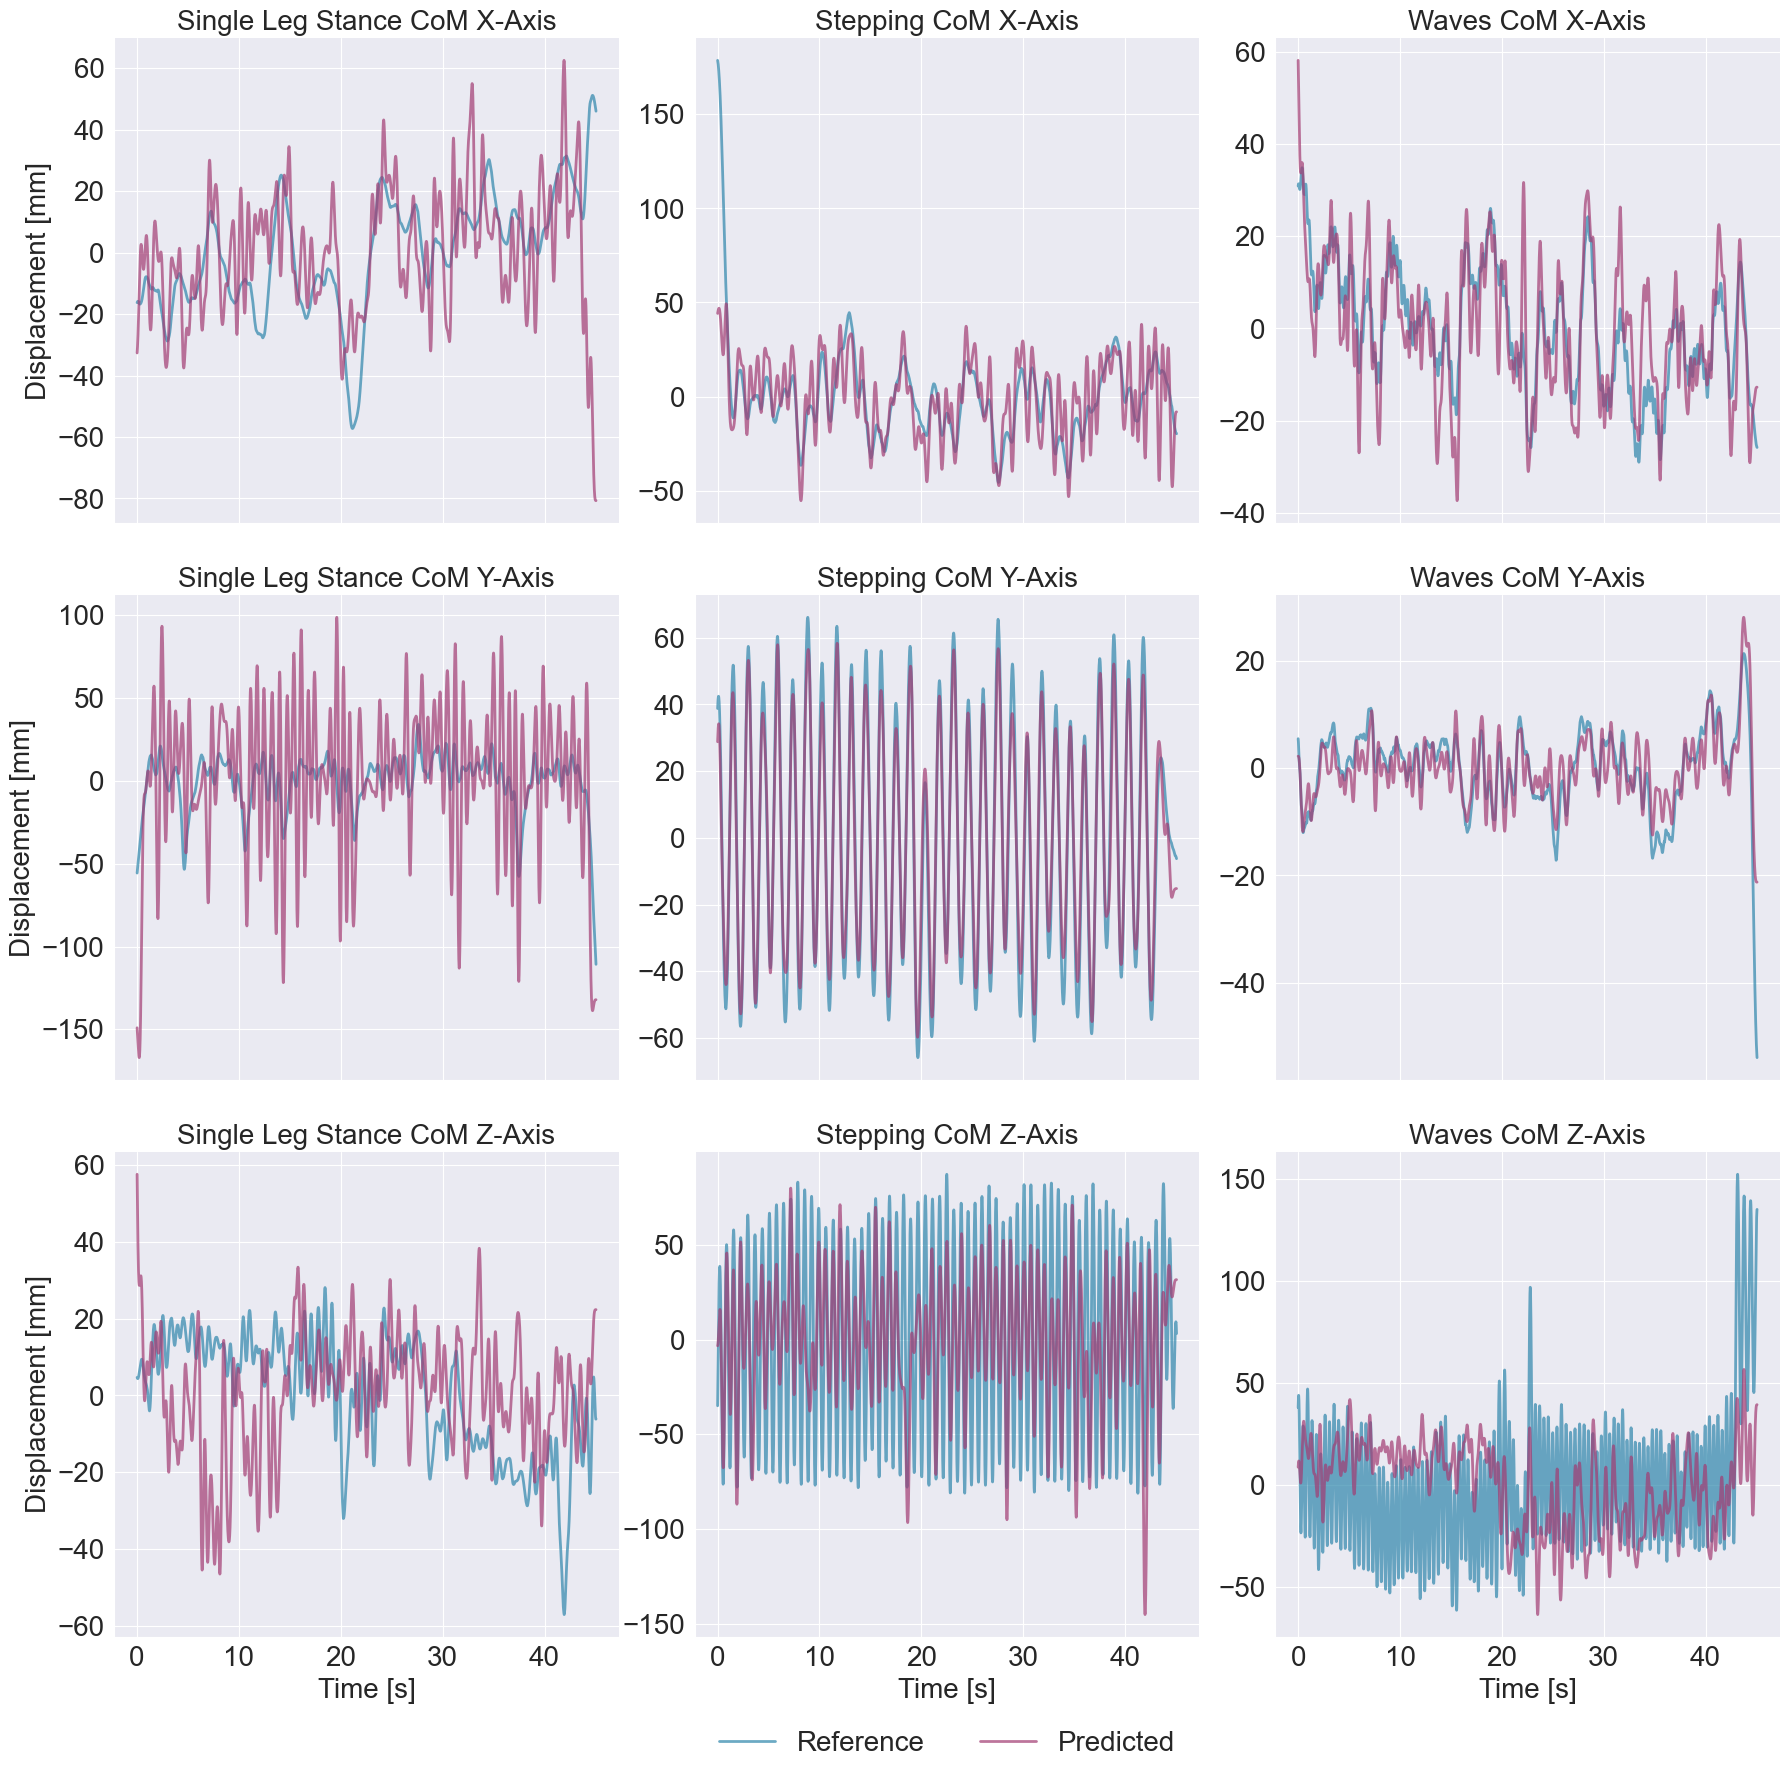


3x3 plot created successfully!


In [17]:
def plot_3x3_comparison(cases_group: List[List[str]],
                        results_dir: str = "results",
                        model_suffix: str = "_centred_DeeperConvLSTMNet_e_10",
                        sampling_frequency: float = 500,
                        cutoff_frequency: float = 20,
                        filter_order: int = 4,
                        figsize: Tuple[int, int] = (18, 18)) -> plt.Figure:
    fig, axes = plt.subplots(3, 3, figsize=figsize, sharex=True)
    axes = axes.flatten()  # Flatten for easier indexing

    reference_color = '#2E86AB'
    predicted_color = '#A23B72'

    for idx, (output_name, exercise, participant_id) in enumerate(cases_group):
        ax = axes[idx]

        model_name = f"{exercise}_{exercise}_{output_name}{model_suffix}"
        filepath = f"../{results_dir}/test_result_{model_name}.csv"
        result_df = pd.read_csv(filepath)
        participant_data = result_df[result_df.id == participant_id]

        predicted_str = participant_data.filtered_predicted.iloc[0]
        expected_str = participant_data.filtered_expected.iloc[0]

        predicted = np.array(literal_eval(predicted_str), dtype=float)
        expected = np.array(literal_eval(expected_str), dtype=float)

        filtered_predicted = butter_lowpass_filter(
            predicted,
            2,
            sampling_frequency,
            filter_order
        )
        filtered_expected = butter_lowpass_filter(
            expected,
            cutoff_frequency,
            sampling_frequency,
            filter_order
        )

        time_vector = np.arange(len(expected)) / sampling_frequency

        ax.plot(time_vector, filtered_expected,
                alpha=0.7,
                label='Reference',
                linewidth=2,
                color=reference_color)

        ax.plot(time_vector, filtered_predicted,
                alpha=0.7,
                label='Predicted',
                linewidth=2,
                color=predicted_color)

        condition_map = {'Sta': 'Single Leg Stance', 'Ste': 'Stepping', 'W': 'Waves'}
        axis_map = {'com_x': 'CoM X-Axis', 'com_y': 'CoM Y-Axis', 'com_z': 'CoM Z-Axis'}

        ax.set_title(
            f"{condition_map.get(exercise, exercise)} {axis_map.get(output_name, output_name)}",
            fontsize=font_size
        )

        # Only add x-label to bottom row
        if idx >= 6:
            ax.set_xlabel("Time [s]", fontsize=font_size)

        # Only add y-label to leftmost column
        if idx % 3 == 0:
            ax.set_ylabel("Displacement [mm]", fontsize=font_size)

        ax.tick_params(labelsize=font_size)
        ax.spines[['right', 'top']].set_visible(False)

        # Add legend only to the first subplot
        if idx == 0:
            pass
            #ax.legend(loc='best', frameon=False)

    plt.tight_layout()
    return fig


def create_combined_plot(mean_cases: List[List[str]],
                         results_dir: str = "results",
                         model_suffix: str = "_centred_DeeperConvLSTMNet_e_10",
                         save_figure: bool = False,
                         output_dir: str = "plots",
                         filename: str = "com_all_conditions_3x3.png") -> plt.Figure:
    if save_figure:
        os.makedirs(output_dir, exist_ok=True)

    fig = plot_3x3_comparison(
        cases_group=mean_cases,
        results_dir=results_dir,
        model_suffix=model_suffix
    )

    if save_figure:
        plt.legend(fontsize=font_size, bbox_to_anchor=(-0.65, -0.30), fancybox=False, shadow=False, ncol=2,
                   loc='lower center', facecolor='white', framealpha=1, frameon=False)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.15, hspace=0.15)

        fig.savefig(f"{output_dir}/{filename}", dpi=600, bbox_inches='tight')
        print(f"  Saved: {output_dir}/{filename}")

    plt.show()
    return fig

mean_cases = [
    ['com_x', 'Sta', 'ION'],  # X-axis Static
    ['com_x', 'Ste', 'VWM'],  # X-axis Step
    ['com_x', 'W', 'ION'],  # X-axis Walking
    ['com_y', 'Sta', 'NIN'],  # Y-axis Static
    ['com_y', 'Ste', 'SXN'],  # Y-axis Step
    ['com_y', 'W', 'BDN'],  # Y-axis Walking
    ['com_z', 'Sta', 'KOD'],  # Z-axis Static
    ['com_z', 'Ste', 'LON'],  # Z-axis Step
    ['com_z', 'W', 'NIN']  # Z-axis Walking
]

figure = create_combined_plot(
    mean_cases=mean_cases,
    save_figure=True,
    output_dir="grouped_plots"
)

print("\n3x3 plot created successfully!")

count     64.000000
mean      26.443243
std       20.686952
min        5.547659
25%       13.517089
50%       19.520734
75%       30.837179
max      124.619357
Name: value, dtype: float64
count    64.000000
mean     23.730790
std       6.180943
min      16.385437
25%      21.318801
50%      23.273278
75%      24.422899
max      66.241440
Name: value, dtype: float64
Plot 1: Sta_com_x_centred
  Linear Model - Mean: 26.443, Std: 20.525 Min: 5.548 Max: 124.619 Med: 19.521
  LSTM - Mean: 23.731, Std: 6.132 Min: 16.385 Max: 66.241 Med: 23.273
count     64.000000
mean      26.754647
std       21.214632
min        7.924433
25%       12.838410
50%       17.962848
75%       32.803537
max      126.530535
Name: value, dtype: float64
count    64.000000
mean     17.129667
std       3.670618
min      12.010684
25%      14.768628
50%      15.876166
75%      19.074280
max      31.145354
Name: value, dtype: float64
Plot 2: Ste_com_x_centred
  Linear Model - Mean: 26.755, Std: 21.048 Min: 7.924 Max: 126.

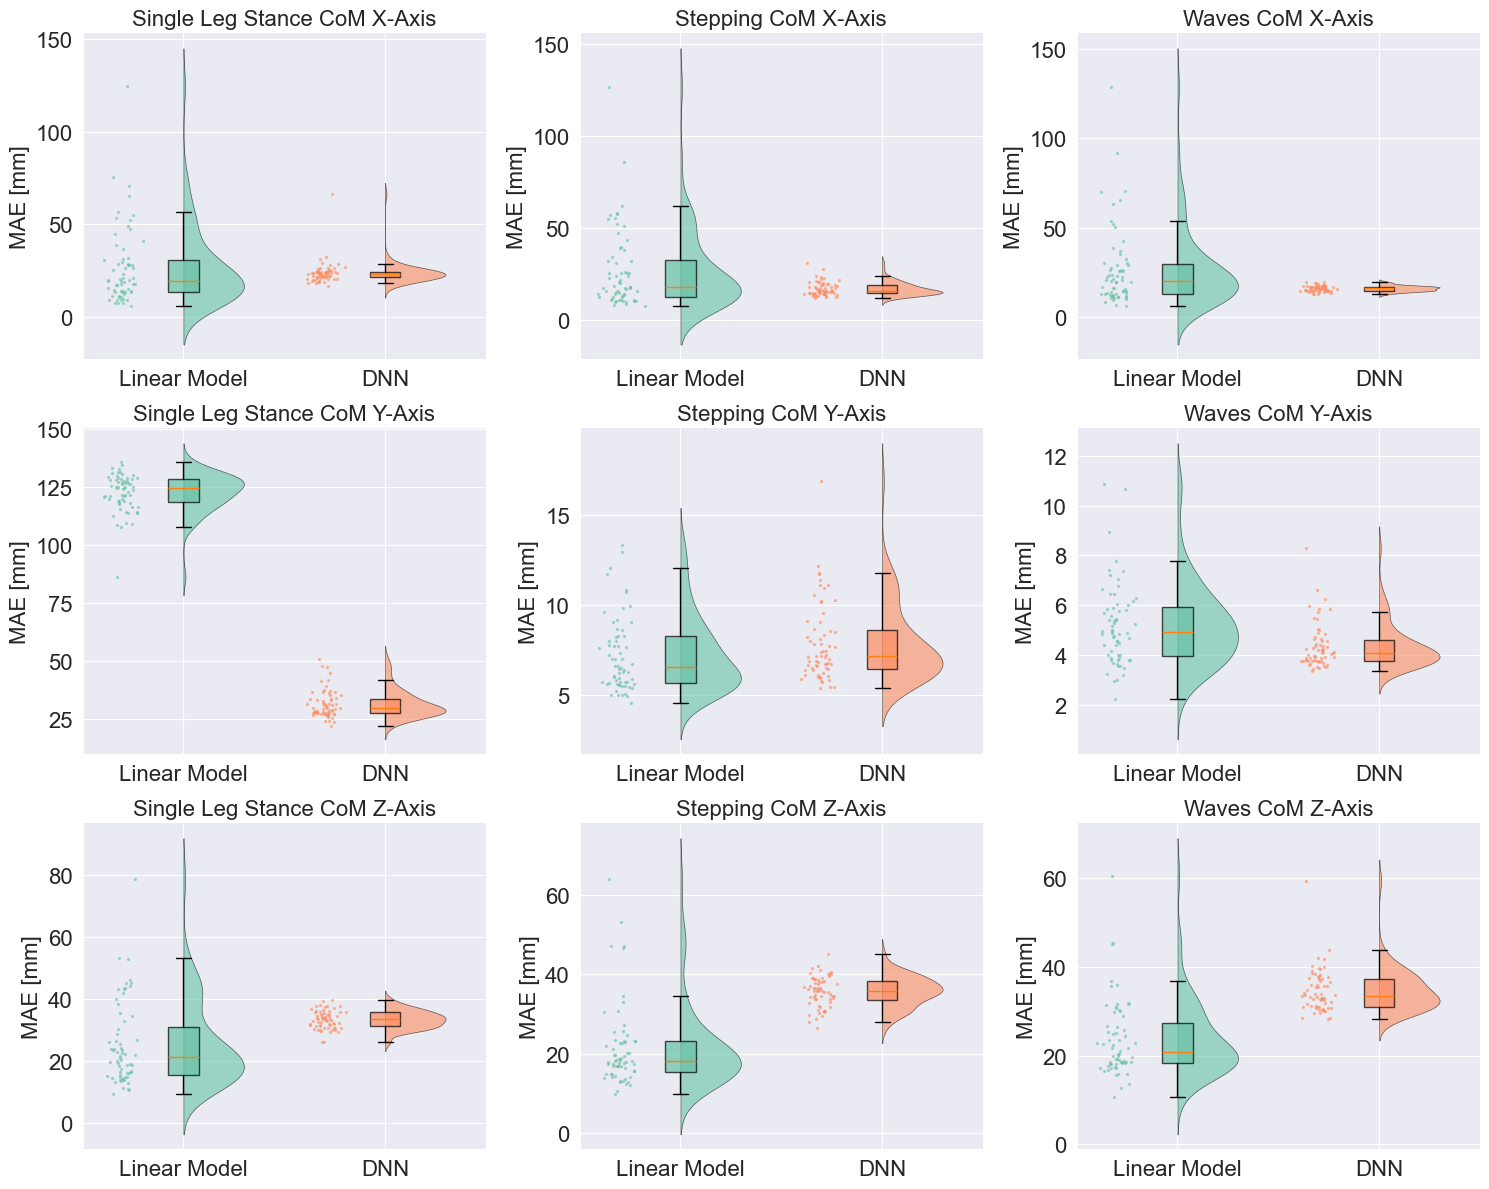


Summary statistics saved to plots/summary_statistics.csv


In [24]:
def enhanced_raincloud_ax(ax,
                          df,
                          value_col,
                          group_col,
                          palette='Set2',  # green/red 
                          orient='v',
                          point_size=2,
                          plot_half=True,
                          plot_title=""):
    if orient == 'v':
        x, y = group_col, value_col
        hue_var = x
    else:
        x, y = value_col, group_col
        hue_var = y

    if plot_half:
        groups = df[group_col].unique()
        colors_list = sns.color_palette(palette, len(groups))

        if orient == 'v':
            for i, group in enumerate(groups):
                group_data = df[df[group_col] == group][value_col].values

                # Half violin using KDE
                kde = gaussian_kde(group_data)
                y_vals = np.linspace(group_data.min() - group_data.std(),
                                     group_data.max() + group_data.std(), 100)
                density = kde(y_vals)
                density = density / np.max(density) * 0.3

                # Plot half violin on the right
                x_right = i + density
                ax.fill_betweenx(y_vals, i, x_right, alpha=0.6, color=colors_list[i],
                                 edgecolor='black', linewidth=0.5)

                ax.boxplot([group_data], positions=[i], widths=0.15,
                           patch_artist=True, showfliers=False,
                           boxprops=dict(facecolor=colors_list[i], alpha=0.7))

                print((df[df[group_col] == group][value_col]).describe())

                # Strip plot
                x_pos = np.full(len(group_data), i - 0.3)
                x_jitter = x_pos + np.random.normal(0, 0.04, len(group_data))
                ax.scatter(
                    x_jitter,
                    group_data,
                    s=point_size,
                    alpha=0.5,
                    color=colors_list[i]
                )

            ax.set_xticks(range(len(groups)))
            ax.set_xticklabels(groups)
            ax.set_ylabel(value_col)

    font_size_title = 16
    font_size_labels = 16

    ax.set_title(subtitle_mapping[plot_title], fontsize=font_size_title)
    ax.set_xlabel("", fontsize=font_size_labels)
    ax.set_ylabel("MAE [mm]", fontsize=font_size_labels)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=font_size_labels)


def create_raincloud_grid(output_names, exercises, figsize=(15, 12), dpi=600):
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()  # Flatten for easier iteration

    means_lin = []
    stds_lin = []
    mins_lin = []
    maxs_lin = []
    meds_lin = []

    means_ai = []
    stds_ai = []
    mins_ai = []
    maxs_ai = []
    meds_ai = []

    plot_idx = 0

    for output_name in output_names:
        for exercise in exercises:
            model_name = exercise + f'_{exercise}_{output_name}_centred_DeeperConvLSTMNet_e_10'
            filepath_lin = f"../results/statistics_simple_model_{model_name}.csv"
            filepath_ai = f"../results/statistics_{model_name}.csv"

            statistics_df = pd.read_csv(filepath_lin)
            statistics_ai_df = pd.read_csv(filepath_ai)

            final_name = "_".join(model_name.split("_")[1:])
            final_name = final_name.split("_Deep")[0]

            array1 = np.array(statistics_df["d_mean"])
            array2 = np.array(statistics_ai_df["d_mean"])

            means_lin.append(np.mean(array1))
            stds_lin.append(np.std(array1))
            mins_lin.append(np.min(array1))
            maxs_lin.append(np.max(array1))
            meds_lin.append(np.median(array1))

            means_ai.append(np.mean(array2))
            stds_ai.append(np.std(array2))
            mins_ai.append(np.min(array2))
            maxs_ai.append(np.max(array2))
            meds_ai.append(np.median(array2))

            df = pd.DataFrame({
                'value': np.concatenate([array1, array2]),
                'group': ['Linear Model'] * len(array1) + ['DNN'] * len(array2)
            })

            enhanced_raincloud_ax(
                axes[plot_idx],
                df,
                'value',
                'group',
                palette='Set2',
                plot_title=final_name
            )

            print(f"Plot {plot_idx + 1}: {final_name}")
            print(
                f"  Linear Model - Mean: {means_lin[-1]:.3f}, Std: {stds_lin[-1]:.3f} Min: {mins_lin[-1]:.3f} Max: {maxs_lin[-1]:.3f} Med: {meds_lin[-1]:.3f}")
            print(
                f"  LSTM - Mean: {means_ai[-1]:.3f}, Std: {stds_ai[-1]:.3f} Min: {mins_ai[-1]:.3f} Max: {maxs_ai[-1]:.3f} Med: {meds_ai[-1]:.3f}")

            plot_idx += 1

    for idx in range(plot_idx, 9):
        axes[idx].set_visible(False)

    plt.tight_layout()

    save_path = "../plots/raincloud_grid_3x3.png"
    fig.savefig(save_path, dpi=dpi, bbox_inches='tight')
    print(f"\nGrid plot saved to {save_path}")

    return fig, axes, means_lin, stds_lin, means_ai, stds_ai


fig, axes, means_lin, stds_lin, means_ai, stds_ai = create_raincloud_grid(
    output_names, exercises, figsize=(15, 12), dpi=600
)

plt.show()

summary_df = pd.DataFrame({
    'Linear_Mean': means_lin,
    'Linear_Std': stds_lin,
    'AI_Mean': means_ai,
    'AI_Std': stds_ai
})
summary_df.to_csv('../plots/summary_statistics.csv', index=False)
print("\nSummary statistics saved to plots/summary_statistics.csv")


C:\Users\simplay\AppData\Local\Temp\ipykernel_20244\1701104014.py:65: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


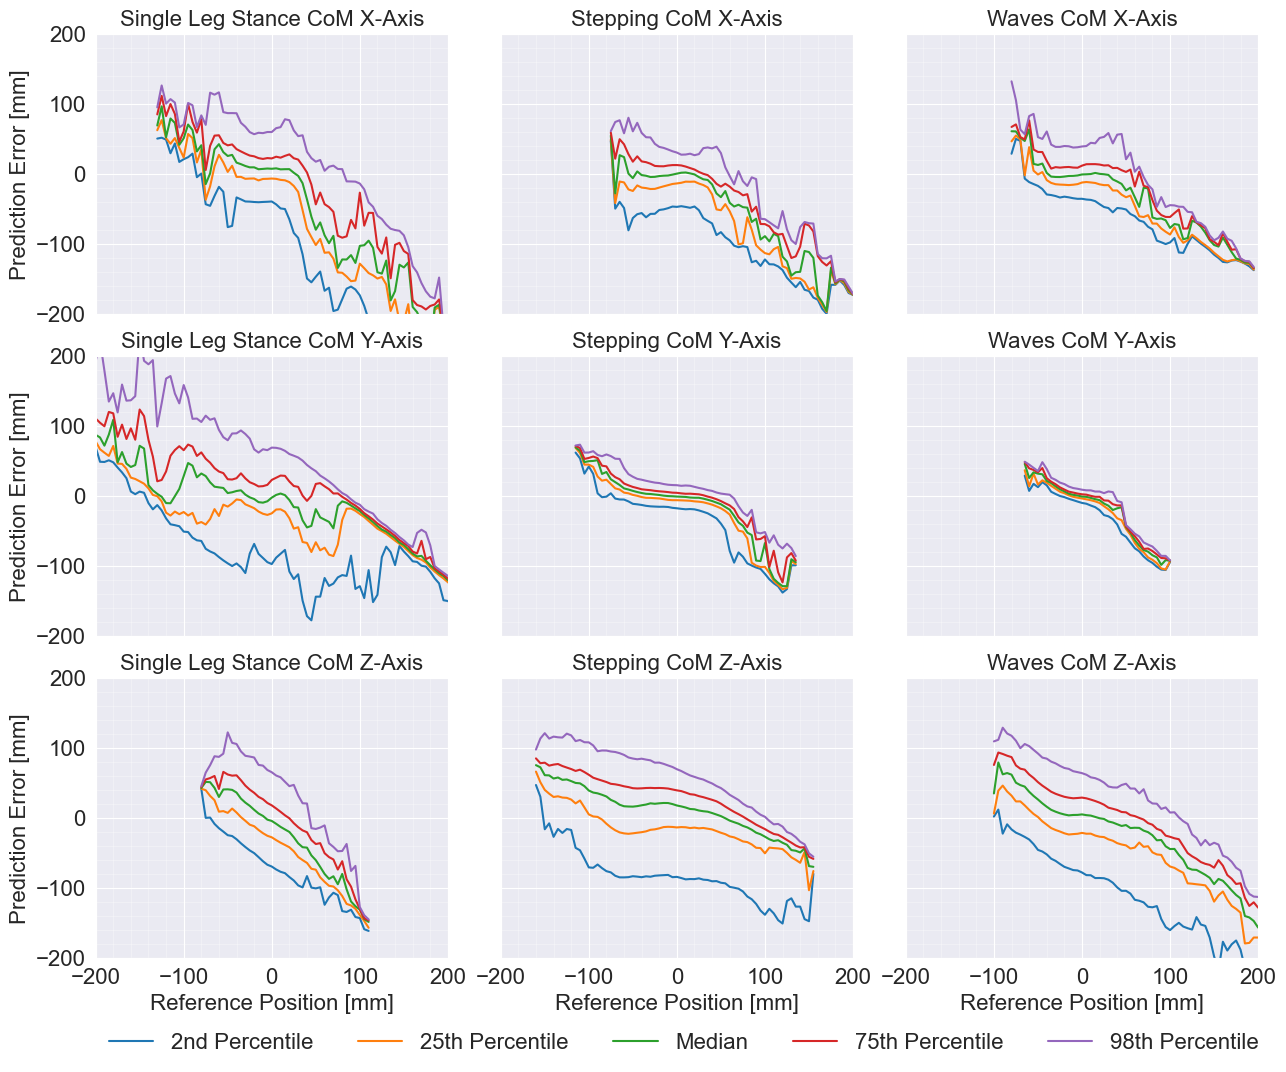

In [25]:
with open('../results/prediction_error_statistics.json') as f:
    all_statistic_errors = json.load(f)

idx = 0
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)
for i, output_name in enumerate(output_names):
    for j, exercise in enumerate(exercises):
        target_dataset_name = f"{output_name}-{exercise}"
        statistics_errs = all_statistic_errors[target_dataset_name]
        range_values = [int(item) for item in statistics_errs.keys()]
        all_error_statistics = list(statistics_errs.values())
        ys0 = [k[0] for k in all_error_statistics]
        ys1 = [k[1] for k in all_error_statistics]
        ys2 = [k[2] for k in all_error_statistics]
        ys3 = [k[3] for k in all_error_statistics]
        ys4 = [k[4] for k in all_error_statistics]

        show_x_label = True if idx in [6, 7, 8] else False
        show_y_label = True if idx in [0, 3, 6] else False

        ax = axes[i, j]

        ax.plot(range_values, ys0, label="2nd Percentile")
        ax.plot(range_values, ys1, label="25th Percentile")
        ax.plot(range_values, ys2, label="Median")
        ax.plot(range_values, ys3, label="75th Percentile")
        ax.plot(range_values, ys4, label="98th Percentile")

        font_size_title = 16
        font_size_labels = 16

        ax.set_xlim([-200, 200])
        ax.set_ylim([-200, 200])
        ax.set_title(propper_naming_map[target_dataset_name], fontsize=font_size_title)

        if show_x_label:
            ax.set_xlabel("Reference Position [mm]", fontsize=font_size_labels)

        if show_y_label:
            ax.set_ylabel("Prediction Error [mm]", fontsize=font_size_labels)

        if idx == 7:
            #ax.legend(fontsize=12, loc="best", frameon=False)
            #ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0, -1), fancybox=True, shadow=True, ncol=1)
            pass

        ax.grid(True, which="minor", alpha=0.3)
        ax.tick_params(labelsize=font_size_labels)

        # Major ticks every 20, minor ticks every 5
        major_ticks = np.arange(-200, 220, 100)
        minor_ticks = np.arange(-200, 220, 20)
        ax.set_xticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        ax.set_yticks(major_ticks)
        ax.set_yticks(minor_ticks, minor=True)

        idx += 1

#plt.legend(fontsize=12, bbox_to_anchor=(0.0, -0.25), fancybox=True, shadow=False, ncol=5)

plt.legend(fontsize=16, bbox_to_anchor=(-0.63, -0.41), fancybox=False, shadow=False, ncol=5, loc='lower center', facecolor='white', framealpha=1, frameon=False)


plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.15)
save_path = "../plots/prediction_error_3x3.png"
fig.savefig(save_path, dpi=600, bbox_inches='tight')

{
    "com_x-Sta": {
        "-130.0": 125,
        "-125.0": 58,
        "-120.0": 48,
        "-115.0": 48,
        "-110.0": 45,
        "-105.0": 44,
        "-100.0": 43,
        "-95.0": 47,
        "-90.0": 53,
        "-85.0": 51,
        "-80.0": 53,
        "-75.0": 473,
        "-70.0": 764,
        "-65.0": 1329,
        "-60.0": 2168,
        "-55.0": 2496,
        "-50.0": 4516,
        "-45.0": 7929,
        "-40.0": 12682,
        "-35.0": 17601,
        "-30.0": 29622,
        "-25.0": 53120,
        "-20.0": 81989,
        "-15.0": 123817,
        "-10.0": 172635,
        "-5.0": 224915,
        "0.0": 226933,
        "5.0": 181245,
        "10.0": 120473,
        "15.0": 74294,
        "20.0": 44928,
        "25.0": 19618,
        "30.0": 10590,
        "35.0": 6021,
        "40.0": 3021,
        "45.0": 2019,
        "50.0": 1646,
        "55.0": 1707,
        "60.0": 1440,
        "65.0": 605,
        "70.0": 381,
        "75.0": 685,
        "80.0": 607,
        "

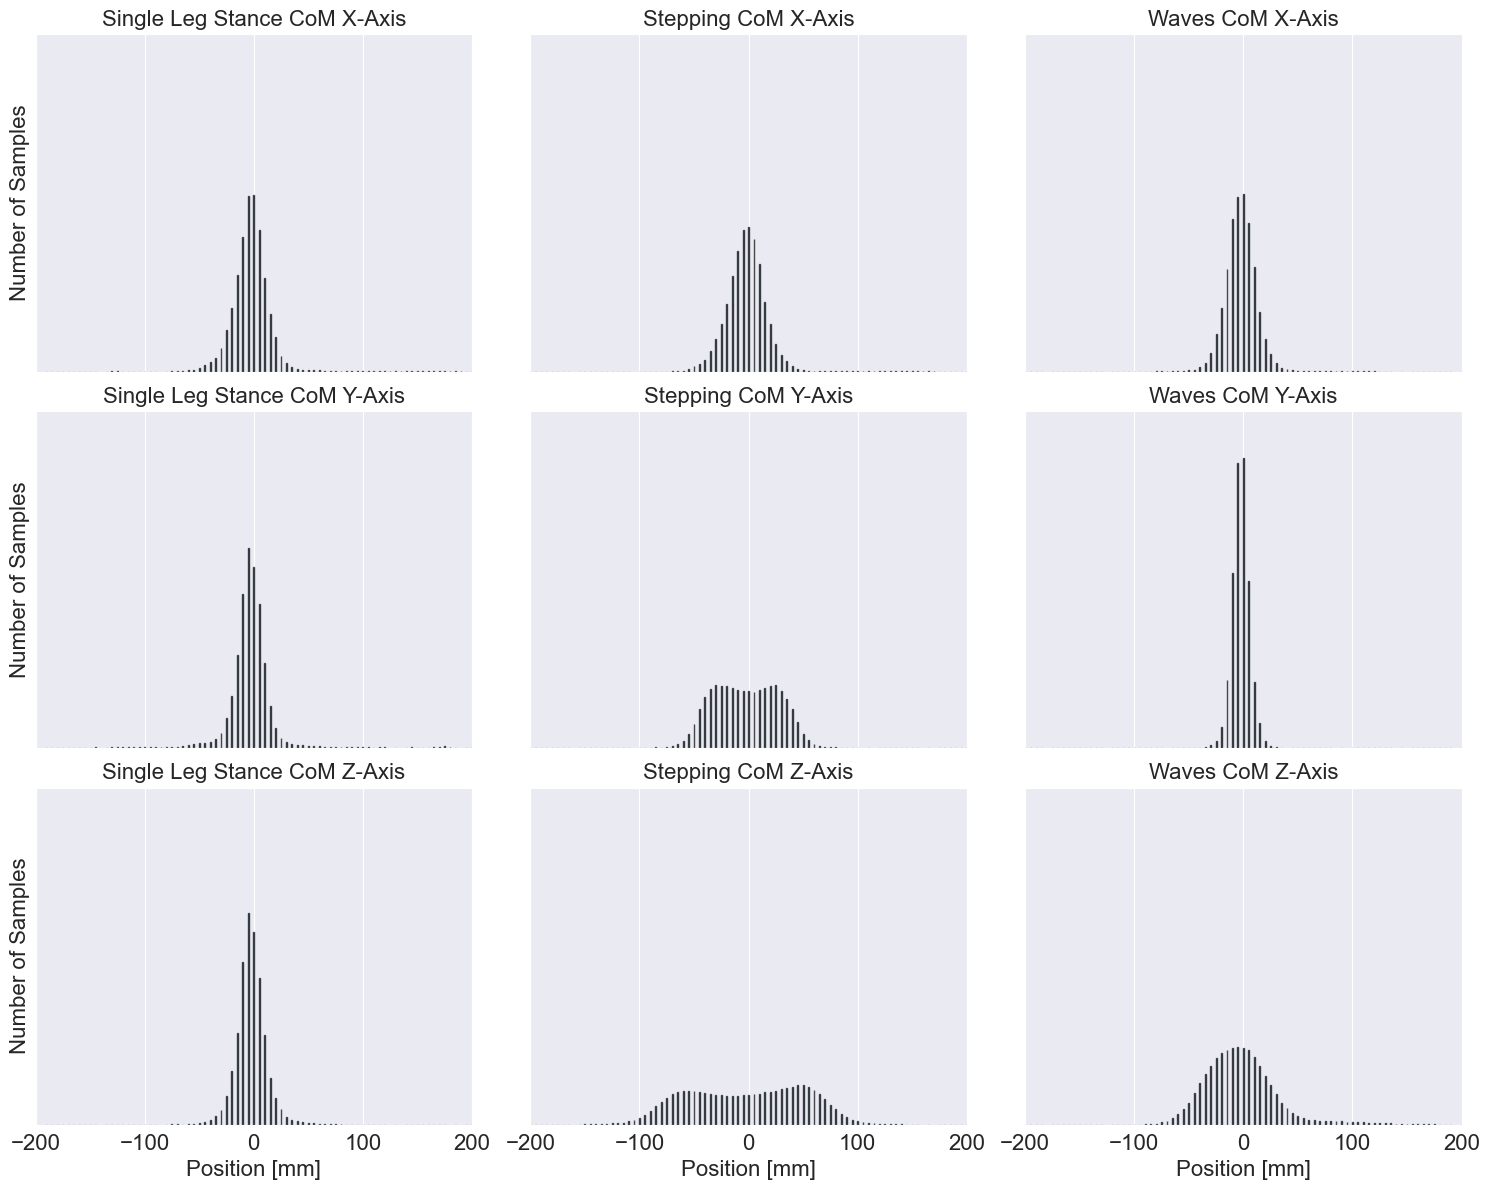

In [74]:
import json

with open('../results/prediction_error_bin_distributions.json') as f:
    all_bin_stats = json.load(f)
    print(json.dumps(all_bin_stats, indent=4))


def plot_histogram_from_dict(ax,
                             data_dict,
                             title="",
                             xlabel="Position [mm]",
                             ylabel="Number of Samples",
                             show_xlable=False,
                             show_ylable=False):
    keys = list(data_dict.keys())
    values = list(data_dict.values())

    ax.bar(keys, values, color='steelblue', edgecolor='black', alpha=0.7)
    font_size = 16

    if show_xlable:
        ax.set_xlabel(xlabel, fontsize=font_size)

    if show_ylable:
        ax.set_ylabel(ylabel, fontsize=font_size)

    ax.set_title(title, fontsize=font_size)
    ax.grid(True, axis='y', which="minor", alpha=0.3)
    ax.set_ylim([0, 0.3])
    ax.set_xlim([-200, 200])
    ax.set_yticks([])

    # ax.grid(True, which="minor", alpha=0.3)
    ax.tick_params(labelsize=font_size_labels)

    # Major ticks every 20, minor ticks every 5
    major_ticks = np.arange(-200, 220, 100)
    minor_ticks = np.arange(-200, 220, 20)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)

    return fig, ax


fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)
axes_flat = axes.flatten()

for idx, dataset_name in enumerate(all_bin_stats.keys()):
    normalized_bin_counts = dict([[5 * (float(item) - 40), 0] for item in range(81)])
    N = np.sum([np.sum(float(item)) for item in all_bin_stats[dataset_name].values()])
    for k, v in all_bin_stats[dataset_name].items():
        normalized_bin_counts[int(float(k))] = v / N

    show_x_label = True if idx in [6, 7, 8] else False
    show_y_label = True if idx in [0, 3, 6] else False

    plot_histogram_from_dict(
        axes_flat[idx],
        normalized_bin_counts,
        title=propper_naming_map[dataset_name],
        show_xlable=show_x_label,
        show_ylable=show_y_label
    )

plt.tight_layout()
plt.savefig("../plots/sample_histogram.png", dpi=600, bbox_inches='tight')
plt.show()